In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from torch.utils.data import WeightedRandomSampler
import sys

In [2]:
STATE = 0
torch.set_printoptions(threshold=sys.maxsize)

# First part of the homework

In [3]:
df = pd.read_csv('HW4_hr-analytics.csv')
df.rename(columns={'average_montly_hours': 'average_monthly_hours', 'sales': 'department'}, inplace=True)
df

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


### Predict turnover rate with decision tree

In [4]:
one_hot_list = ['department', 'salary']

df_one_hot_encoding = pd.get_dummies(df, columns = one_hot_list)
df_one_hot_encoding

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_IT,department_RandD,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [5]:
# Split the dataset into 70% of the training set and 30% of the test set
y = df_one_hot_encoding["left"]
x = df_one_hot_encoding.drop(columns=["left"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=STATE)

In [6]:
clf = DecisionTreeClassifier(random_state=STATE)
clf.fit(x_train, y_train)
pred_left = clf.predict(x_test)
score = clf.score(x_test, y_test)
print(f"Accuracy: {score}")

Accuracy: 0.9784444444444444


In [7]:
# Plot the confusion matrix to better understand the model
def plot_confusion_matrix(pred):
    plt.figure(figsize=(5, 5))
    cm = metrics.confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

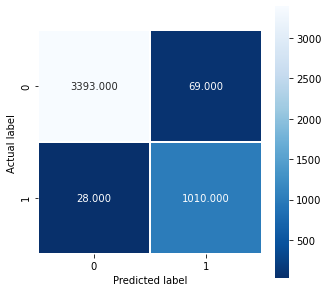

In [8]:
plot_confusion_matrix(pred_left)

### Predict turnover rate with neural network

In [9]:
class Mlp(nn.Module):
    def __init__(self, input_num):
        super().__init__()
        self.num = 256
        self.model = nn.Sequential(
            nn.Linear(input_num, self.num),
            nn.ReLU(),
            nn.Linear(self.num, self.num*2),
            nn.ReLU(),
            nn.Linear(self.num*2, self.num*2),
            nn.ReLU(),
            nn.Linear(self.num*2, self.num*4),
            nn.ReLU(),
            nn.Linear(self.num*4, 1),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
class MyDataset(Dataset):
    def __init__(self):    
        self.x_data = torch.tensor(x_train.values, dtype=torch.float32)
        self.y_data = torch.tensor(y_train.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
    
    def __str__(self):
        #return f"x size: {self.x_data.size()}, y size: {self.y_data.size()}"
        return f"{class_sample_count}"

In [11]:
# Apply the same feature transformation as in HW3
df_trans = df.copy()
df_trans = df_trans.drop(columns=["department", "salary"])
df_trans['satisfaction_level'] = np.power(df['satisfaction_level'], 2)
df_trans['time_spend_company'] = np.sqrt(np.max(df['time_spend_company']) - df['time_spend_company'])
df_trans['number_project'] = np.power(df['number_project'], 2)
df_trans['last_evaluation'] = np.sqrt(np.max(df['last_evaluation']) - df['last_evaluation'])
df_trans['average_monthly_hours'] = np.sqrt(np.max(df['average_monthly_hours']) - df['average_monthly_hours'])

In [12]:
scaler = StandardScaler()
scaler.fit(df_trans)

StandardScaler()

In [13]:
# Split the dataset into 70% of the training set and 30% of the test set
y = df_trans["left"]
x = df_trans.drop(columns=["left"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=STATE)

In [14]:
mlp = Mlp(input_num=7)

In [15]:
data = MyDataset()
train_loader = DataLoader(data, batch_size=32, shuffle=True, drop_last=False)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [16]:
def train(epoch, model, optimizer):
    mlp.train()
    for i in range(epoch):
        for batch_idx, data in enumerate(train_loader):
            feature = data[0]
            target = data[1]
            pred = model(feature)
            loss = criterion(pred.squeeze(), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx+1 == 100:
                print(f"Epoch {i+1}, Loss: {loss}")
    print("Finished training")

In [17]:
train(model=mlp, epoch=20, optimizer=optimizer)

Epoch 1, Loss: 0.06779628247022629
Epoch 2, Loss: 0.059036049991846085
Epoch 3, Loss: 0.08647695928812027
Epoch 4, Loss: 0.08065123856067657
Epoch 5, Loss: 0.06659961491823196
Epoch 6, Loss: 0.1058933436870575
Epoch 7, Loss: 0.026881182566285133
Epoch 8, Loss: 0.17223796248435974
Epoch 9, Loss: 0.08589455485343933
Epoch 10, Loss: 0.09143287688493729
Epoch 11, Loss: 0.010889551602303982
Epoch 12, Loss: 0.04335738345980644
Epoch 13, Loss: 0.038815274834632874
Epoch 14, Loss: 0.058829523622989655
Epoch 15, Loss: 0.012619566172361374
Epoch 16, Loss: 0.015716377645730972
Epoch 17, Loss: 0.010333264246582985
Epoch 18, Loss: 0.10311886668205261
Epoch 19, Loss: 0.044327232986688614
Epoch 20, Loss: 0.05879611894488335
Finished training


In [18]:
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [19]:
mlp.eval()
pred_left = []
correct = 0
acc = None
for i in range(len(x_test_tensor)):
    y = mlp(x_test_tensor[i])
    if y >= 0.5:
        y = 1
    else:
        y = 0
        
    pred_left.append(y)
    
    if y == y_test_tensor[i]:
        correct += 1
acc = correct / len(x_test_tensor)
print(f"Accuracy: {acc}")

Accuracy: 0.9515555555555556


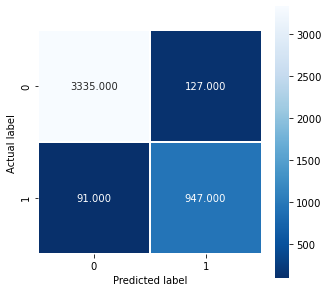

In [20]:
plot_confusion_matrix(pred_left)

討論:
    利用Decision tree和神經網路對非線性的資料處理效果和利用Logistic regression相比有大幅的提升，其中利用Decision tree的準確度最高(98%)，推測可能因Decision tree能夠將不同特徵和結果分得很細，針對非線性的資料處理有較好的效果，不過有overfitting的可能，利用神經網路的準確率也很高(95%)，經過多層的非線性轉換後能使模型更了解特徵和結果的關係，不過需將資料做一些轉換或標準化才會有較好的效果，

# Second part of the homework

In [21]:
df = pd.read_csv("HW4_creditcard.csv")

In [22]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,143360,0.087399,1.955498,-3.009114,-0.611771,2.046245,-2.034809,1.783189,-0.513037,0.091237,...,-0.141101,0.084483,-0.294411,-0.768857,-0.046838,0.087448,0.314269,0.014855,1.82,0
1,163005,-1.969644,-0.434381,-0.203709,-0.048957,0.395736,-1.529643,1.029201,0.203756,-0.248148,...,0.125004,-0.380350,0.365091,0.268591,0.121702,-0.128947,-0.069325,-0.061543,238.28,0
2,151325,2.062615,-1.187470,-2.940538,-1.878575,1.946530,3.129848,-0.704875,0.659123,-0.672128,...,0.101048,0.046789,0.135103,0.722574,0.049329,-0.226307,-0.038544,-0.058289,89.20,0
3,169962,-1.736890,1.276816,0.353397,-0.648723,-0.052977,-0.262870,0.223275,0.533696,0.415933,...,-0.471583,-1.238002,-0.246385,0.460213,0.454608,0.249480,0.217606,0.016917,64.94,0
4,3760,1.401276,-0.683958,-0.915143,-1.616304,1.458234,3.274761,-1.170329,0.710345,0.360104,...,-0.278087,-0.898279,0.081211,0.920023,0.357016,-0.508385,-0.019937,0.015447,42.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28919,67659,1.208510,-1.608221,0.403127,-1.465710,-1.592717,0.066524,-1.233841,0.205880,-1.713045,...,-0.260568,-0.759445,0.073831,-0.398662,-0.034086,-0.384216,0.020646,0.029675,132.00,0
28920,163646,1.997085,-0.334976,-0.305136,0.356486,-0.825710,-0.878371,-0.523938,-0.037454,1.507587,...,-0.131976,-0.297754,0.369404,-0.046107,-0.409260,-0.922612,0.051540,-0.029423,1.00,0
28921,151403,-0.607254,1.037853,0.180245,-0.974243,1.066338,-0.552829,1.173086,-0.394738,-0.019722,...,-0.224596,-0.264097,-0.027561,-0.463851,-0.863171,0.032642,0.070639,0.134187,5.38,0
28922,58304,1.276545,-0.141506,0.278940,-0.197487,-0.382798,-0.209766,-0.360697,0.080531,0.233241,...,-0.139368,-0.478909,-0.015475,-0.470974,0.173173,0.908495,-0.079702,-0.008598,10.00,0


### Predict with decision tree

In [23]:
y = df["Class"]
x = df.drop(columns=["Class", "Time"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=STATE)

In [24]:
clf = DecisionTreeClassifier(random_state=STATE)
clf.fit(x_train, y_train)
pred_class = clf.predict(x_test)
score = clf.score(x_test, y_test)
print(f"Accuracy: {score}")

Accuracy: 0.9948144733809634


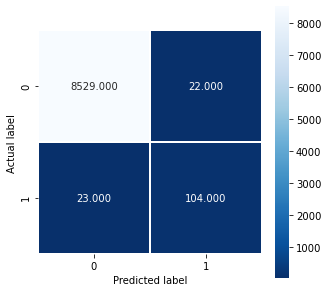

In [25]:
plot_confusion_matrix(pred_class)

In [26]:
# Calculate accuracy, precision, recall and f1-score using the confusion matrix
tp = 8529
fp = 23
tn = 104
fn = 22
acc = (tp + tn) / (tp + fp + tn + fn)
recall = tp / (tp + fp)
precision = tp / (tp + fn)
f1 = 2 * (recall * precision) / (recall + precision)
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")

Accuracy: 0.9948144733809634
Recall: 0.997310570626754
Precision: 0.9974272014969009
F1 score: 0.9973688826521662


利用decision tree效果非常好，即使沒有特別調整權重Accuracy和recall值都很高

### Predict with neural network

In [27]:
# Create the MLP model for prediction
mlp = Mlp(input_num=29)

In [28]:
data = MyDataset()
train_loader = DataLoader(data, batch_size=256, shuffle=True, drop_last=False)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.L1Loss()

In [29]:
train(model=mlp, epoch=10, optimizer=optimizer)

Finished training


In [30]:
def calc():
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
    mlp.eval()
    pred_class = []
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(x_test_tensor)):
        y = mlp(x_test_tensor[i])
        if y >= 0.5:
            y = 1
        else:
            y = 0

        pred_class.append(y)

        if y == y_test_tensor[i]:
            if y == 0:
                tp += 1
            else:
                tn += 1
        else:
            if y == 0:
                fp += 1
            else:
                fn += 1
    acc = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fp)
    precision = tp / (tp + fn)
    f1 = 2 * (recall * precision) / (recall + precision)
    print(f"Accuracy: {acc}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1 score: {f1}")
    return pred_class

In [31]:
pred = calc()

Accuracy: 0.9951601751555658
Recall: 0.9952275637294844
Precision: 0.9998830546134955
F1 score: 0.9975498774938747


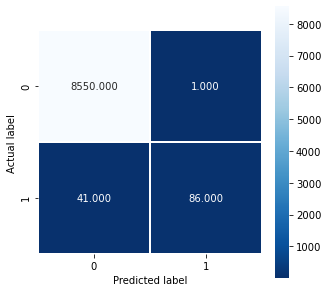

In [32]:
plot_confusion_matrix(pred)

利用神經網路的效果沒有decision tree那麼好，有時會因為資料不均導致訓練不穩定的關係，導致模型全輸出都是1或0

In [33]:
# Check if there's data imbalance
df['Class'].value_counts()

0    28432
1      492
Name: Class, dtype: int64

資料明顯失衡，1的比例只占全部的1%

###  Configure the weights or parameters in the decision tree and neural network in attempt to increase recall

In [34]:
y = df["Class"]
x = df.drop(columns=["Class", "Time"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=STATE)

In [35]:
data = MyDataset()

# increase the chance of class 1 data being sampled
class_sample_count = np.array(
    [len(np.where(y_train.values == t)[0]) for t in np.unique(y_train.values)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train.values])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(data, batch_size=256, shuffle=True, drop_last=False)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = torch.nn.BCELoss(reduction='none')

In [36]:
# Add sigmoid function after the last linear layer because of binary cross entropy loss
class Mlp_bce(nn.Module):
    def __init__(self, input_num):
        super().__init__()
        self.num = 256
        self.model = nn.Sequential(
            nn.Linear(input_num, self.num),
            nn.ReLU(),
            nn.Linear(self.num, self.num*2),
            nn.ReLU(),
            nn.Linear(self.num*2, self.num*2),
            nn.ReLU(),
            nn.Linear(self.num*2, self.num*4),
            nn.ReLU(),
            nn.Linear(self.num*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [37]:
# Make the weight of loss of class 0 a hundredth of that of class 1 in order to compensate the distribution imbalance between two classes
def train_balanced(epoch, model, optimizer):
    mlp.train()
    for i in range(epoch):
        for batch_idx, data in enumerate(train_loader):
            feature = data[0]
            target = data[1]
            pred = model(feature)
            loss = criterion(pred.squeeze(), target)
            optimizer.zero_grad()
            weight = []
            for w in target:
                if w == 1:
                    weight.append(1)
                else:
                    weight.append(1/100)
            weight = torch.tensor(weight)
            loss = torch.mean(weight * loss)
            loss.backward()
            optimizer.step()
            print(f"Epoch {i+1}, Batch {batch_idx+1}, Loss: {loss}")
    print("Finished training")

In [38]:
mlp = Mlp_bce(input_num=29)
train_balanced(model=mlp, epoch=5, optimizer=optimizer)

Epoch 1, Batch 1, Loss: 0.02394968271255493
Epoch 1, Batch 2, Loss: 0.019450360909104347
Epoch 1, Batch 3, Loss: 0.013498244807124138
Epoch 1, Batch 4, Loss: 0.018700463697314262
Epoch 1, Batch 5, Loss: 0.011554637923836708
Epoch 1, Batch 6, Loss: 0.01337229460477829
Epoch 1, Batch 7, Loss: 0.033574990928173065
Epoch 1, Batch 8, Loss: 0.028587065637111664
Epoch 1, Batch 9, Loss: 0.01520520355552435
Epoch 1, Batch 10, Loss: 0.0306793674826622
Epoch 1, Batch 11, Loss: 0.017067497596144676
Epoch 1, Batch 12, Loss: 0.028789835050702095
Epoch 1, Batch 13, Loss: 0.02357548289000988
Epoch 1, Batch 14, Loss: 0.022820331156253815
Epoch 1, Batch 15, Loss: 0.022178683429956436
Epoch 1, Batch 16, Loss: 0.034880563616752625
Epoch 1, Batch 17, Loss: 0.013748852536082268
Epoch 1, Batch 18, Loss: 0.016999224200844765
Epoch 1, Batch 19, Loss: 0.011913017369806767
Epoch 1, Batch 20, Loss: 0.02955150417983532
Epoch 1, Batch 21, Loss: 0.017413169145584106
Epoch 1, Batch 22, Loss: 0.022183168679475784
Epoc

Epoch 3, Batch 29, Loss: 0.011811590753495693
Epoch 3, Batch 30, Loss: 0.013990004546940327
Epoch 3, Batch 31, Loss: 0.03058089315891266
Epoch 3, Batch 32, Loss: 0.03780591860413551
Epoch 3, Batch 33, Loss: 0.04231869801878929
Epoch 3, Batch 34, Loss: 0.01396334357559681
Epoch 3, Batch 35, Loss: 0.027231616899371147
Epoch 3, Batch 36, Loss: 0.011324047110974789
Epoch 3, Batch 37, Loss: 0.015555464662611485
Epoch 3, Batch 38, Loss: 0.03467876836657524
Epoch 3, Batch 39, Loss: 0.031335748732089996
Epoch 3, Batch 40, Loss: 0.05921278893947601
Epoch 3, Batch 41, Loss: 0.027493437752127647
Epoch 3, Batch 42, Loss: 0.008619427680969238
Epoch 3, Batch 43, Loss: 0.025418493896722794
Epoch 3, Batch 44, Loss: 0.014504324644804
Epoch 3, Batch 45, Loss: 0.015649495646357536
Epoch 3, Batch 46, Loss: 0.02253546565771103
Epoch 3, Batch 47, Loss: 0.012978877872228622
Epoch 3, Batch 48, Loss: 0.03481312841176987
Epoch 3, Batch 49, Loss: 0.01179574802517891
Epoch 3, Batch 50, Loss: 0.019674813374876976


Epoch 5, Batch 57, Loss: 0.033725306391716
Epoch 5, Batch 58, Loss: 0.02283611334860325
Epoch 5, Batch 59, Loss: 0.034934937953948975
Epoch 5, Batch 60, Loss: 0.024796636775135994
Epoch 5, Batch 61, Loss: 0.019416680559515953
Epoch 5, Batch 62, Loss: 0.030224958434700966
Epoch 5, Batch 63, Loss: 0.012198387645184994
Epoch 5, Batch 64, Loss: 0.04060535505414009
Epoch 5, Batch 65, Loss: 0.022886889055371284
Epoch 5, Batch 66, Loss: 0.029031287878751755
Epoch 5, Batch 67, Loss: 0.03271569684147835
Epoch 5, Batch 68, Loss: 0.01889972947537899
Epoch 5, Batch 69, Loss: 0.00869204755872488
Epoch 5, Batch 70, Loss: 0.02264012023806572
Epoch 5, Batch 71, Loss: 0.026540644466876984
Epoch 5, Batch 72, Loss: 0.017598826438188553
Epoch 5, Batch 73, Loss: 0.012425361201167107
Epoch 5, Batch 74, Loss: 0.04507624730467796
Epoch 5, Batch 75, Loss: 0.024877484887838364
Epoch 5, Batch 76, Loss: 0.02700716257095337
Epoch 5, Batch 77, Loss: 0.01978638768196106
Epoch 5, Batch 78, Loss: 0.03192458674311638
E

In [39]:
pred = calc()

Accuracy: 0.9595528923715142
Recall: 0.9889100882423086
Precision: 0.9698280902818384
F1 score: 0.9792761409930921


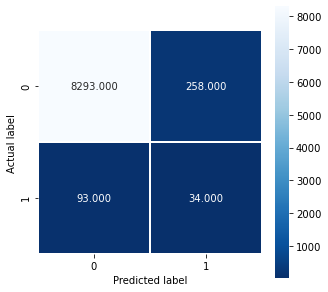

In [40]:
plot_confusion_matrix(pred)

討論:
    即使更改了不同class被取樣的機率和不同class loss的權重比例，效果依然不是很令人滿意，recall大致上沒有增加，且accuracy反而下降了。

In [41]:
y = df["Class"]
x = df.drop(columns=["Class", "Time"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=STATE)

In [42]:
# Adjust the weight of different classes so that the data distribution would be balanced
weights = {0:0.1, 1:10.0}
clf = DecisionTreeClassifier(class_weight=weights, random_state=STATE)
clf.fit(x_train, y_train)
pred_class = clf.predict(x_test)
score = clf.score(x_test, y_test)

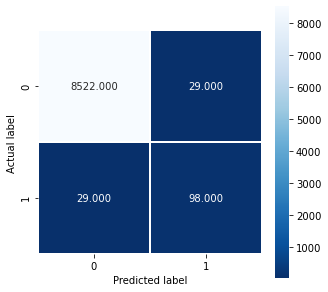

In [43]:
plot_confusion_matrix(pred_class)

In [44]:
tp = 8522
fp = 29
tn = 98
fn = 29
acc = (tp + tn) / (tp + fp + tn + fn)
recall = tp / (tp + fp)
precision = tp / (tp + fn)
f1 = 2 * (recall * precision) / (recall + precision)
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")

Accuracy: 0.9933164323576861
Recall: 0.9966085837913694
Precision: 0.9966085837913694
F1 score: 0.9966085837913694


討論:再更改完權重的佔比後，recall和accuracy並沒有明顯的增加，可能是原本就已經非常高了

### Apply SOMTE to balance the data distribution

In [45]:
# Use SMOTE to balance the data to achieve better result
smote = SMOTE(random_state=STATE)
x_balanced, y_balanced = smote.fit_resample(x, y)
print(y_balanced.value_counts())
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.3, random_state=STATE)

0    28432
1    28432
Name: Class, dtype: int64


In [46]:
clf = DecisionTreeClassifier(random_state=STATE)
clf.fit(x_train, y_train)
pred_class = clf.predict(x_test)
score = clf.score(x_test, y_test)

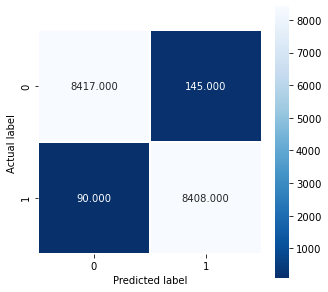

In [47]:
# Plot the confusion matrix to better understand the model
plot_confusion_matrix(pred_class)

In [48]:
tp = 8417
fp = 90
tn = 8408
fn = 145
acc = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fn)
recall = tp / (tp + fp)
f1 = 2 * (recall * precision) / (recall + precision)
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1}")

Accuracy: 0.9862250879249707
Recall: 0.989420477254026
Precision: 0.9830647045082924
F1 score: 0.9862323510457556


In [49]:
mlp = Mlp(input_num=29)
data = MyDataset()
train_loader = DataLoader(data, batch_size=256, shuffle=True, drop_last=False)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.L1Loss()
train(model=mlp, epoch=10, optimizer=optimizer)

Epoch 1, Loss: 0.11065980792045593
Epoch 2, Loss: 0.06930018216371536
Epoch 3, Loss: 0.05050434172153473
Epoch 4, Loss: 0.045725103467702866
Epoch 5, Loss: 0.014644813723862171
Epoch 6, Loss: 0.023434801027178764
Epoch 7, Loss: 0.017661606892943382
Epoch 8, Loss: 0.024257740005850792
Epoch 9, Loss: 0.011041940189898014
Epoch 10, Loss: 0.02038681134581566
Finished training


In [50]:
pred = calc()

Accuracy: 0.9823563892145369
Recall: 0.9692150403271612
Precision: 0.9964961457603364
F1 score: 0.9826662827526634


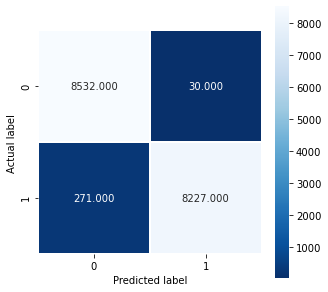

In [51]:
plot_confusion_matrix(pred)

討論:利用SMOTE使資料量平衡後，神經網路和decision tree的效果都沒有很明顯的變好，可能是原本decision tree的效果就還不錯，而神經網路的部分，將資料平衡後，使得訓練較為穩定，不會有模型全部是單一輸出的結果。